# Neuronal entropy

We utilize stored activations for each of the neurons in the layers of interest in the audio encoder of Microsoft's [CLAP](https://github.com/microsoft/CLAP) with respect to the dataset instances in [ESC50](https://github.com/karolpiczak/ESC-50), to compute each neuron's "entropy" defined over a distribution which we define in later sections.

In this notebook, we define the certain distributions over the 50 classes, which we use to characterize each neuron
with respect to the dataset. We then compute these for each neuron in a layer, and plot the spread of the entropy values corresponding to the neurons of each layer.

## Initialization
This section contains necessary setup for the experiment. It can usually be collapsed and the experiment can still be understood without poring over these details.

- [Imports and hyperparameters](#imports-and-hyperparameters)
- [Seeding randomness](#seeding-randomness)
- [Loading the model and dataset](#loading-the-model-and-dataset)
- [Loading the activation values](#loading-activation-values)

### Imports and hyperparameters
We also enlist the layers of interest in this section.

In [1]:
from CLAPWrapper import CLAPWrapper
from esc50_dataset import ESC50
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import re
import numpy as np
from tqdm.notebook import tqdm
from icecream import ic
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable, List

The `module_activation_dict`'s keys are precisely the layers of interest, the activations for which are stored.
The activation functions are needed for our method of activation storage.

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TOP_K = 100
NUM_CLASSES = 50
NUM_INSTANCES = 2000

module_activation_dict = {
    # Conv blocks
    'audio_encoder.base.conv_block1': nn.Identity(),
    'audio_encoder.base.conv_block2': nn.Identity(),
    'audio_encoder.base.conv_block3': nn.Identity(),
    'audio_encoder.base.conv_block4': nn.Identity(),
    'audio_encoder.base.conv_block5': nn.Identity(),
    'audio_encoder.base.conv_block6': nn.Identity(),
    # FC layers
    'audio_encoder.base.fc1': F.relu,
    'audio_encoder.projection.linear1': F.gelu,
    'audio_encoder.projection.linear2': nn.Identity(),
    # Classification pseudo-layer
    'classification_layer': nn.Identity()
}

module_list = list(module_activation_dict.keys())

### Seeding randomness
This is to seed any and all randomness that might be present in the model.  \
This **should** only be the dropout layers in between the projection matrices, and a random sample
of the audio to be taken if the model's input audio duration, does **not** match with
the dataset's input audio duration.  \

The dropout layers should be deactivated after turning the model to evaluation mode, and
CLAP 's expected audio duration does match with ESC-50's audio duration (5 seconds), so this shouldn't matter,
but better to be safe than sorry.


In [3]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
seed_everything(42)

### Loading the model and dataset
#### Loading weights
Microsoft has made the pre-trained weights for CLAP available for download on request [here](https://zenodo.org/record/7312125#.Y22vecvMIQ9).

In [5]:
weights_path = "/scratch/pratyaksh.g/clap/CLAP_weights_2022_microsoft.pth"
clap_model = CLAPWrapper(weights_path, use_cuda=True if DEVICE == "cuda" else False)

In [6]:
clap_model.clap.eval()

CLAP(
  (audio_encoder): AudioEncoder(
    (base): Cnn14(
      (spectrogram_extractor): Spectrogram(
        (stft): STFT(
          (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
          (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
        )
      )
      (logmel_extractor): LogmelFilterBank()
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block1): ConvBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_block2): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

#### Loading dataset
We use the [ESC-50 dataset](https://github.com/karolpiczak/ESC-50), which consists of 2000 recordings across 50 classes of environmental sounds, each 5 seconds long.

In [7]:
dataset = ESC50(root="/scratch/pratyaksh.g/esc50/", download=False)

Using downloaded and verified file: /scratch/pratyaksh.g/esc50/ESC-50-master.zip


2000it [00:00, 11550.88it/s]

Loading audio files


### Loading activation values
We load the pre-computed activation values for each neuron over all the instances in the ESC-50 dataset.

In [8]:
fc_activations = pd.read_csv('/home2/pratyaksh.g/MS-CLAP/data/fc-activations.csv', index_col=0)

end_idx = module_list.index('audio_encoder.base.fc1')
conv_activations = { layer_name: ([None] * NUM_INSTANCES)  for layer_name in module_list[:end_idx] }
for layer_name in tqdm(conv_activations.keys()):
    for i, act_pt in enumerate(tqdm(os.listdir(f'/home2/pratyaksh.g/MS-CLAP/data/conv-activations/{layer_name}'))):
        if i % 250 == 00
            print(f'Loading: /home2/pratyaksh.g/MS-CLAP/data/conv-activations/{layer_name}/{act_pt}')
        act = torch.load(f'/home2/pratyaksh.g/MS-CLAP/data/conv-activations/{layer_name}/{act_pt}')
        pt_idx = int(re.search('act-(\d+).pt', act_pt).group(1))
        conv_activations[layer_name][pt_idx] = act

for layer_name in tqdm(conv_activations.keys()):
    conv_activations[layer_name] = torch.cat(conv_activations[layer_name], dim=0)

)
ic| f'Loading: /home2/pratyaksh.g/MS-CLAP/data/conv-activations/{layer_name}/{act_pt}': ('Loading: '
                                                                                         '/home2/pratyaksh.g/MS-CLAP/data/conv-activations/audio_encoder.base.conv_block1/act-1279.pt')
ic| f'Loading: /home2/pratyaksh.g/MS-CLAP/data/conv-activations/{layer_name}/{act_pt}': ('Loading: '
                                                                                         '/home2/pratyaksh.g/MS-CLAP/data/conv-activations/audio_encoder.base.conv_block1/act-1054.pt')
ic| f'Loading: /home2/pratyaksh.g/MS-CLAP/data/conv-activations/{layer_name}/{act_pt}': ('Loading: '
                                                                                         '/home2/pratyaksh.g/MS-CLAP/data/conv-activations/audio_encoder.base.conv_block1/act-623.pt')
ic| f'Loading: /home2/pratyaksh.g/MS-CLAP/data/conv-activations/{layer_name}/{act_pt}': ('Loading: '
                                           

In [ ]:
conv_activations['audio_encoder.base.conv_block1']

## Computing entropy values

We define two distributions which are of interest to us: the **participation probability** distribution, and **the cumulative activation** distribution.

### Participation probability distribution
This distribution is computed for a neuron in the following manner:
1. Take the top $K$ (we take $K = 100$) most activating dataset instances, i.e.
   the dataset instances whose activation value is the greatest. If there are less
   than $K$ instances from the dataset that *positively* activate the neuron, then let
   $K$ be the number of dataset instances that positively activate the neuron.
2. For each class in the dataset, find the count of instances belonging to that
   class which are in the top $K$ for the given neuron.
3. Divide these class counts by $K$, to get our distribution.

This is a probability distribution, over the dataset classes. It gives the probability of a given instance belonging to a certain dataset class when randomly picked from the top $K$ maximally activating dataset instances for the given neuron.

For eg: if $K = 10$ and there are only 3 classes (dog, cat, cow), the probability distribution might look like [0.3, 0.3, 0.4]. This means that in the top 10 maximally activating dataset instances, there were 3 which belonged to the class 'dog', 3 to 'cat', and 4 to 'cow'.
 

Mathematically it can be described as such:

> TODO: Add mathematical formula for this distribution

In [ ]:
def participation_probability_distribution(top_k_activations : pd.DataFrame) -> List[float]:
    """
    Given a dataframe containing the top k activations for a given sample,
    compute the participation probability distribution, and return it as a list
    in the same order as the classes in the ESC-50 dataset.
    """
    if len(top_k_activations) == 0:
        return [0.0 for class_idx in range(NUM_CLASSES)]

    # Now compute the count vector for each class, and then the class probabilities
    class_counts = top_k_activations.groupby('class_idx').count()['activation'].to_dict()
    class_probs = {class_idx: class_counts.get(class_idx, 0) / len(top_k_activations) for class_idx in range(NUM_CLASSES)}

    return list(class_probs.values())

The participation probability distribution earlier had the problem that we considered a constant $K$ for all neurons. For neurons which did not have at least $K$ positively activating dataset examples, this meant that instances with zero activation would also creep up, adding noise. To deal with this, we added the clause for $K$ to be adjusted in that special case.

However, there is another issue still: in the participation probability distribution, the instance at rank 1 is no different from the instance at rank 100, i.e. there is no weightage given to how much each instance activates the neuron. We address this with the cumulative activation distribution.

### Cumulative activation distribution

This distribution is computed for a neuron in the following manner:

1. Take the top $K$ (we take $K = 100$) most activating dataset instances.
2. For each class in the dataset, find the instances in the top $K$ belonging to this class,
   and take the sum of the activation values for each of these instances.
3. Do this for each class and then normalize by dividing by the sum of all activation values for that neuron

The distribution we have as a result represents the contribution of each class to the neuron's maximal activations, weighted by the actual activation values. While the normalization technically makes it a valid probability distribution, it does not really represent the probability for any specific event.

Mathematically, it can be described as such:
> TODO: Add mathematical formula for this distribution

In [ ]:
def cumulative_activation_distribution(top_k_activations : pd.DataFrame) -> List[float]:
    """
    Given a dataframe containing the top k activations for a given sample,
    compute the , and return it as a list
    in the same order as the classes in the ESC-50 dataset.
    """
    if len(top_k_activations) == 0:
        return [0.0 for class_idx in range(NUM_CLASSES)]

    # Now compute the cumulative activation for each class, and then the classwise distribution
    cumulative_activations = top_k_activations.groupby('class_idx').sum()['activation'].to_dict()
    cumulative_dist = {class_idx: cumulative_activations.get(class_idx, 0) for class_idx in range(NUM_CLASSES)}

    # And then normalize it
    cumulative_dist = {class_idx: cumulative_dist[class_idx] / sum(cumulative_dist.values()) for class_idx in range(NUM_CLASSES)}

    return list(cumulative_dist.values())

The distribution earlier had the issue that not all layers have an activation function that guarantees positive outputs. As a result, the cumulative activation could end up not being truly representative due to the presence of negative values.

(Is this true? I don't completely understand the issues here yet: note that we only consider the positive activations in the actual computation of anything from the top K dataset instances.)
> TODO: Better understand the issue, and figure out an appropriate solution. Listen to the Otter note before that.

Additionally, I tried to use softmax instead of normalization, but this had terrible results. Those results can be shown near the end.

### Computing the distributions
The code for each distribution explained earlier is made easier to read, since we can use the below utility
function to directly apply it. We then compute both the distributions for all the neurons in each layer.

In [ ]:
def compute_classwise_distributions(distribution_function : Callable[[pd.DataFrame], List[float]]):
    """
    Utility function which computes the classwise distribution for each neuron in the network,
    given some distribution function. The distribution function is applied to the top K patches.
    
    As a type annotiation in tuple notation (for my own reference):
        distribution_function: (pd.DataFrame) -> List[float]
    i.e. df of top activations for a neuron -> classwise distribution
    """
    layer_wise_distributions = []
    for layer_idx, layer_name in enumerate(module_list):
        num_neurons = len(activations[activations['layer_idx'] == layer_idx]['neuron_idx'].unique())
        neuron_wise_distributions = []

        for neuron_idx in tqdm(range(num_neurons)):
            # For each neuron, get the TOP_K non-zero patches
            neuron_activations = activations[(activations['layer_idx'] == layer_idx) & (activations['neuron_idx'] == neuron_idx)]
            neuron_activations = neuron_activations[neuron_activations['activation'] > 0]
            neuron_activations = neuron_activations.sort_values(by='activation', ascending=False)
            neuron_activations = neuron_activations.head(TOP_K)

            # Get the distribution for that specific neuron using the user's provided function
            dist = distribution_function(neuron_activations)

            # Append the class probability distribution to the list for this layer
            neuron_wise_distributions.append(dist)

        layer_wise_distributions.append(neuron_wise_distributions)
    return layer_wise_distributions

We use the shorter terms akin to `participation_dist` and `cumulative_dist` to refer to the participation probability distributions and the cumulative activation distributions respectively.

In [ ]:
participation_dist = compute_classwise_distributions(participation_probability_distribution)

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
cumulative_dist = compute_classwise_distributions(cumulative_activation_distribution)

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### Computing and storing entropy values
We now compute the Shannon entropy in bits (log base 2) for each of these distributions, and store all of these together in a Pandas DataFrame, and write it to a CSV.

All this is information about the neurons with respect to the entire dataset, so we name the dataframe `neurons`.

In [ ]:
def shannon_entropy(dist):
    entropy = 0
    for p in dist:
        if p > 0:
            entropy -= p * np.log2(p)
    return entropy

In [ ]:
neurons = pd.DataFrame(columns=['layer_idx', 'neuron_idx',
                                'participation_dist', 'cumulative_dist',
                                'participation_entropy', 'cumulative_entropy'])

for layer_idx, layer_name in enumerate(tqdm(module_list)):
    num_neurons = len(activations[activations['layer_idx'] == layer_idx]['neuron_idx'].unique())

    for neuron_idx in tqdm(range(num_neurons)):
        neuron_pd = participation_dist[layer_idx][neuron_idx]
        neuron_cd = cumulative_dist[layer_idx][neuron_idx]

        # In case of a dead neuron, assign a zero entropy
        if (sum(neuron_pd) == 0) and (sum(neuron_cd) == 0):
            neurons.loc[len(neurons)] = [
                layer_idx, neuron_idx,
                neuron_pd, neuron_cd,
                0.0, 0.0
            ]
            continue

        # sanity check: check that the distributions sum to 1
        assert np.isclose(sum(neuron_pd), 1.0) and np.isclose(sum(neuron_cd), 1.0)

        # We compute it for the neuron and add it to the entropies dataframe
        pd_entropy = shannon_entropy(neuron_pd)
        cd_entropy = shannon_entropy(neuron_cd)

        # Another sanity check: assert that entropy is 0 only if the distribution is deterministic
        # assert np.isclose(pd_entropy, 0.0, atol=1e-32) == (1.0 in neuron_pd), (pd_entropy, neuron_pd)
        # assert np.isclose(cd_entropy, 0.0, atol=1e-32) == (1.0 in neuron_cd), (cd_entropy, neuron_cd)

        neurons.loc[len(neurons)] = [
            layer_idx, neuron_idx, 
            neuron_pd, neuron_cd,
            pd_entropy, cd_entropy
        ]

neurons.to_csv('/home2/pratyaksh.g/MS-CLAP/data/neurons.csv')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## Plotting entropies

In [ ]:
def plot_entropies(modules_to_plot=range(len(module_list)), entropy_type='participation'):
    # Now we plot the entropies for each layer as a histogram with a KDE plot
    sns.set_style('whitegrid')
    sns.set_context('notebook')
    sns.set_palette('muted')
    fig, ax = plt.subplots(figsize=(8, 6))

    ent_typ = entropy_type + '_entropy'

    data = neurons[(neurons['layer_idx'].isin(modules_to_plot)) & (neurons[ent_typ] > 0)]
    # Set the density to True so that the histogram is normalized
    sns.histplot(data=data, x=ent_typ, hue='layer_idx', kde=True, ax=ax, stat='density', common_norm=False, bins=30)

    # Also plot the median entropy for each layer
    for layer_idx in modules_to_plot:
        median_entropy = data[data['layer_idx'] == layer_idx][ent_typ].median()
        print(f'Layer {layer_idx} Median Entropy: {median_entropy:.4f}')

        ax.axvline(median_entropy, color=f'C{layer_idx}', linestyle='-.', label=f'Layer {layer_idx} Median')
        plt.annotate(f'{layer_idx}', xy=(median_entropy, plt.ylim()[1]), xytext=(0, 0),
                textcoords='offset points', ha='center', va='bottom', color='black')

    plt.savefig('/home2/pratyaksh.g/MS-CLAP/fig/entropy.png', dpi=300)
    plt.show()
    plt.close()

Layer 0 Median Entropy: 2.8882
Layer 1 Median Entropy: 2.8253
Layer 2 Median Entropy: 3.1271
Layer 3 Median Entropy: 2.6879


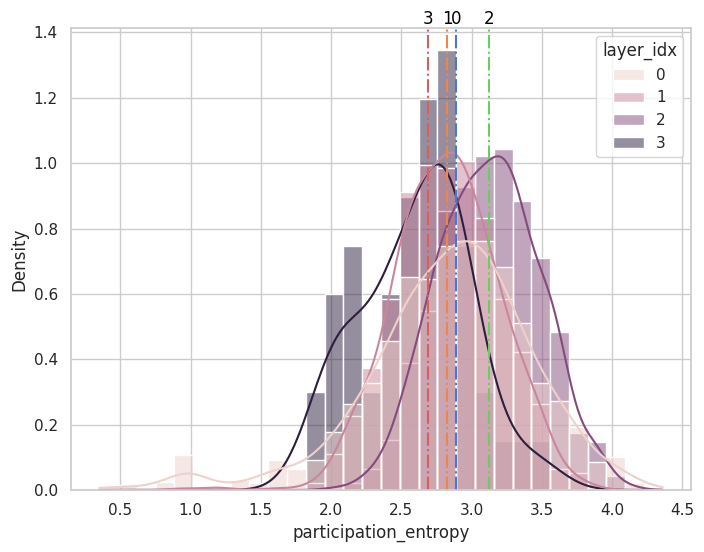

In [ ]:
plot_entropies(entropy_type='participation')

Layer 0 Median Entropy: 2.6926
Layer 1 Median Entropy: 2.5649
Layer 2 Median Entropy: 3.0120
Layer 3 Median Entropy: 1.1642


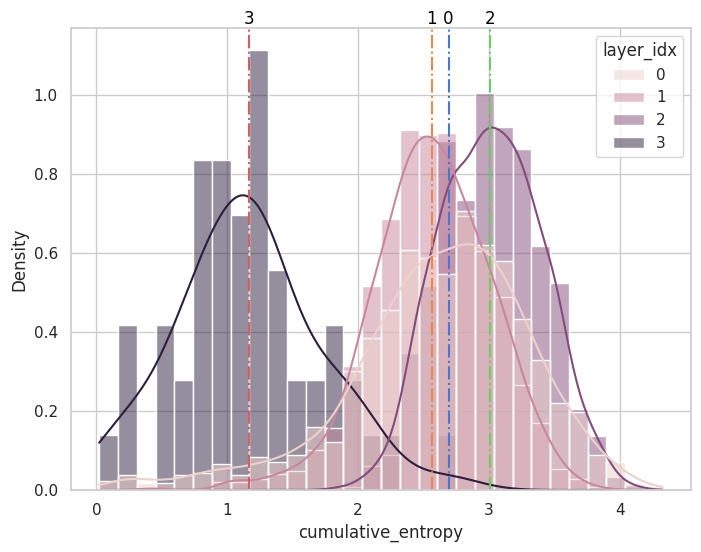

In [ ]:
plot_entropies(entropy_type='cumulative')

## Additional Observations

### Dual neurons in layer 0
If you look closely at the layer 0 entropy distribution, we can see there's a small bump near 1.0, which we don't see in the other layers. An entropy of 1.0 corresponds to a 0.5 probability of being one of two classes. We inspect which neurons actually have an entropy close to 1.0 (turns out, for a tolerance of 0.01, they're *all* in layer 0).

Layer 0 Median Entropy: 2.8882


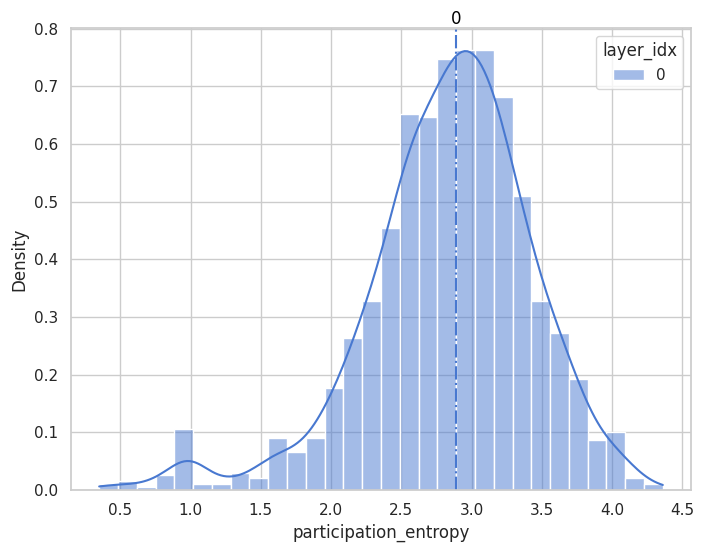

In [ ]:
plot_entropies([0])

In [ ]:
dual_neurons = neurons[np.isclose(neurons['participation_entropy'], 1.0, atol=1e-2)]
dual_neurons

,layer_idx,neuron_idx,participation_dist,cumulative_dist,participation_entropy,cumulative_entropy
245,0,245,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01964857876012387, 0.01964857876012387, 0.0...",1.0,5.639003
260,0,260,"[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.020101912691091066, 0.019979607268549592, 0...",1.0,5.643828
604,0,604,"[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02242477034530337, 0.01994520765890601, 0.0...",1.0,5.643645
659,0,659,"[0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.019841632062952464, 0.019841632062952464, 0...",1.0,5.642184
965,0,965,"[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.020277623319229523, 0.019980037738320026, 0...",1.0,5.643836
982,0,982,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01995405707536657, 0.01995405707536657, 0.0...",1.0,5.643757
1121,0,1121,"[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02105756012721195, 0.019971548816589905, 0....",1.0,5.643812
1242,0,1242,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.019966343648392594, 0.019966343648392594, 0...",1.0,5.643786
1309,0,1309,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.019537140000533127, 0.019537140000533127, 0...",1.0,5.632256
1499,0,1499,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.019975579074834236, 0.019975579074834236, 0...",1.0,5.643825


We can take a closer look at these neurons and what classes they're perfectly split over.

In [ ]:
# Find the indices where the probabilities are 0.5
dual_neurons['participation_dist'].apply(lambda x: tuple(map(lambda y: dataset.classes[y], np.where(np.isclose(x, 0.5, 1e-4))[0])))

245     (footsteps, mouse click)
260           (dog, mouse click)
604           (dog, mouse click)
659           (pig, mouse click)
965           (dog, can opening)
982     (footsteps, mouse click)
1121             (dog, coughing)
1242    (footsteps, mouse click)
1309      (clock tick, chainsaw)
1499    (footsteps, mouse click)
1576             (dog, coughing)
1620          (dog, mouse click)
1739      (breathing, footsteps)
1794    (footsteps, mouse click)
1836    (footsteps, mouse click)
1889    (footsteps, mouse click)
Name: participation_dist, dtype: object